<a href="https://colab.research.google.com/github/edolior/DL_Siamese/blob/main/DL_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.initializers import RandomNormal
from skimage import io
import time
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

download the zip lfwa from https://drive.google.com/file/d/1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp/view and the unzip it

In [ ]:
!unzip /content/lfwa.zip

Streaming output truncated to the last 5000 lines.
 extracting: lfw2/lfw2/Pak_Gil_Yon/Pak_Gil_Yon_0001.jpg  
   creating: lfw2/lfw2/Pamela_Anderson/
 extracting: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0001.jpg  
  inflating: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0002.jpg  
 extracting: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0003.jpg  
  inflating: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0004.jpg  
 extracting: lfw2/lfw2/Pamela_Anderson/Pamela_Anderson_0005.jpg  
   creating: lfw2/lfw2/Pamela_Melroy/
 extracting: lfw2/lfw2/Pamela_Melroy/Pamela_Melroy_0001.jpg  
   creating: lfw2/lfw2/Paola_Espinoza/
  inflating: lfw2/lfw2/Paola_Espinoza/Paola_Espinoza_0001.jpg  
   creating: lfw2/lfw2/Paradorn_Srichaphan/
 extracting: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0001.jpg  
 extracting: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0002.jpg  
 extracting: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_Srichaphan_0003.jpg  
  inflating: lfw2/lfw2/Paradorn_Srichaphan/Paradorn_

Change the path to the folder containing the images folders

In [ ]:
path = '/content/lfw2/lfw2'

#split test train

In [ ]:
def duplicate_name(row):
  try:
    data = row.split(',')
    if len(data) == 3:
      data.insert(2, data[0])
      data.insert(4, 1) # true
    else:
      data.insert(4, 0)# false
    return data
  except:
    print(row)
    return row

In [ ]:
def txt_pairs_to_pd(url):
  df = pd.read_csv(url, header = None)
  df[0] = df[0].apply(lambda x: x.replace("\t",','))
  df = df[1:]
  df = df[0].apply(lambda x: duplicate_name(x))
  df = pd.DataFrame(df.to_list(), columns=['folder1', 'image1', 'folder2', 'image2', 'class'])
  df['image1'] = df.image1.apply(lambda x: f"{x:0>4}") #pad with zeros in order to create the pattern of images files
  df['image2'] = df.image2.apply(lambda x: f"{x:0>4}")
  return df

In [ ]:
train_pairs = txt_pairs_to_pd('http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt')
test_pairs = txt_pairs_to_pd('http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt')

#data exploration

## train

In [ ]:
train_pairs.describe()

class
count  2200.000000
mean      0.500000
std       0.500114
min       0.000000
25%       0.000000
50%       0.500000
75%       1.000000
max       1.000000

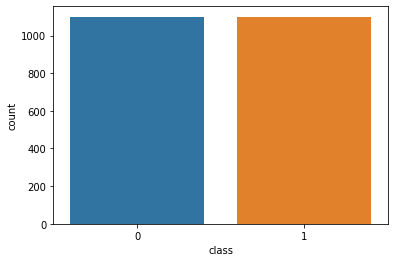

In [ ]:
ax_train = sns.countplot(x="class",data=train_pairs)

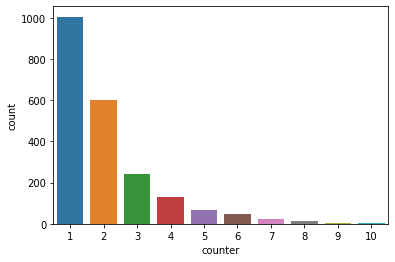

In [ ]:
people_train = np.concatenate((train_pairs.folder1.values , train_pairs.folder2.values))
unique_train, counts_train = np.unique(people_train, return_counts=True)
people_train_count =  pd.DataFrame(np.asarray((unique_train, counts_train)).T, columns=['name','counter'])
ax_count_train = sns.countplot(x="counter",data=people_train_count)

## test

In [ ]:
test_pairs.describe()

class
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000

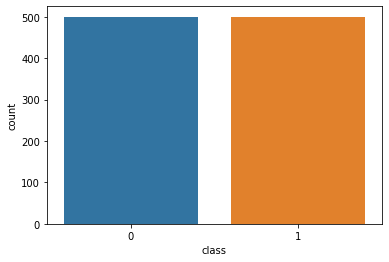

In [ ]:
ax_test = sns.countplot(x="class",data=test_pairs)

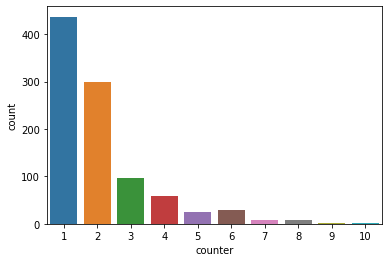

In [ ]:
people_test = np.concatenate((test_pairs.folder1.values , test_pairs.folder2.values))
unique_test, counts_test = np.unique(people_test, return_counts=True)
people_test_count =  pd.DataFrame(np.asarray((unique_test, counts_test)).T, columns=['name','counter'])
ax_count_test = sns.countplot(x="counter",data=people_test_count)

# load images

In [ ]:
train_pairs

folder1 image1               folder2 image2  class
0           Aaron_Peirsol   0001         Aaron_Peirsol   0002      1
1           Aaron_Peirsol   0003         Aaron_Peirsol   0004      1
2            Aaron_Sorkin   0001          Aaron_Sorkin   0002      1
3     Abdel_Nasser_Assidi   0001   Abdel_Nasser_Assidi   0002      1
4                Abdullah   0001              Abdullah   0003      1
...                   ...    ...                   ...    ...    ...
2195          Tom_Vilsack   0001        Wayne_Ferreira   0005      0
2196         Trisha_Meili   0001  Vladimiro_Montesinos   0003      0
2197             Ty_Votaw   0001          Wayne_Allard   0001      0
2198       Vytas_Danelius   0001        Zaini_Abdullah   0001      0
2199        Wendy_Kennedy   0001        Zara_Akhmadova   0001      0

[2200 rows x 5 columns]

In [ ]:
df = train_pairs.sample(frac=1).reset_index(drop=True)

In [ ]:
train_X = df.drop(columns='class')
train_Y = df['class']
test_pairs = test_pairs.sample(frac=1).reset_index(drop=True)
test_X = test_pairs.drop(columns='class')
test_Y = test_pairs['class']

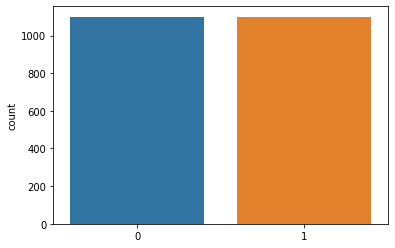

In [ ]:
ax_train_after_split = sns.countplot(x=train_Y.values)

In [ ]:
print(len(train_X))
print(len(train_Y))
print(len(test_X))
print(len(test_Y))

2200
2200
1000
1000


In [ ]:
def load_image_data(train_X):
    """
    load all images to DF
    output: data frame with name, image index and the image array
    """
    train_L = []
    train_R = []
    for i in range(len(train_X)):
        image_index_1 = f"{train_X.loc[i]['folder1']}/{train_X.loc[i]['folder1']}_{train_X.loc[i]['image1']}.jpg"
        image_index_2 = f"{train_X.loc[i]['folder2']}/{train_X.loc[i]['folder2']}_{train_X.loc[i]['image2']}.jpg"
        train_L.append(mpimg.imread(os.path.join(path, image_index_1)))
        train_R.append(mpimg.imread(os.path.join(path, image_index_2)))
    return train_L, train_R

def stack_values(train_L, train_R):
    return np.stack(train_L,axis=0), np.stack(train_R,axis=0)

In [ ]:
train_L, train_R = load_image_data(train_X)
train_L, train_R = stack_values(train_L, train_R)

#Siamese Network

In [ ]:
def plot_trainig_results(results):
    """
    plot training results accuracy and loss
    """
    plt.plot(results.history['accuracy'])
    plt.plot(results.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.plot(results.history['loss'])
    plt.plot(results.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
def crop_image(data, h, w, resizer=1):
    """
    change the focus and size of the image.
    """
    _, width, height = data.shape
    new_h = height - h - resizer
    new_w = width - w - resizer
    return data[:, h:new_h, w:new_w]

In [ ]:
l2 = tf.keras.regularizers.l2
class Siamese_Network:

    def __init__(self, img_shape, lr, lr_decay, l2_reg, is_batch_norm, opt, epochs, batch_size, normlize_input, is_early_stopping):
        '''
        img_shape - the shape of the input - (105,105,1) /  (250,250,1)
        lr - the starting learning rate
        lr_decay- the factor for reducing lr
        l2_reg- dict of l2 normalization of every conv layer
        is_batch_norm- true if should add batch norm after each cov layer, else false
        opt- string of "adam" or "sgd" to choose optimizer
        normlize_input - boolean, if true  we normlize the input (divide by 255)
        is_early_stopping- boolean, if true if we stop after no improvment on the validation for 8 epochs
        '''
        self.img_shape = img_shape
        self.s_model = []
        self.lr = lr
        self.optimizer = opt
        self.epochs = epochs
        self.batch_size = batch_size
        self.build_model(lr_decay, l2_reg, is_batch_norm)
        self.lr_decay = lr_decay
        self.normlize_input = normlize_input
        self.is_early_stopping = is_early_stopping

    def plateu_and_early_stop(self, params):
        stop = tf.keras.callbacks.EarlyStopping(monitor=params, patience=8, verbose=1, min_delta=1e-4, restore_best_weights=True)
        plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor=params, factor=self.lr_decay, patience=4, verbose=1, min_delta=1e-4)
        if self.is_early_stopping:
            return [stop, plateu]
        else:
            return [plateu]

    def build_model(self, lr_decay, l2_reg, is_batch_norm):
        #input size
        w_1 = RandomNormal(mean=0, stddev=0.01)
        b = RandomNormal(mean=0.5, stddev = 0.01)
        w_2 = RandomNormal(mean=0, stddev=0.2)

        in_1 = tf.keras.Input(self.img_shape)
        in_2 = tf.keras.Input(self.img_shape)

        net = tf.keras.Sequential()
        net.add(tf.keras.layers.Conv2D(64,(10,10),activation='relu',input_shape=self.img_shape, kernel_initializer=w_1, bias_initializer= b))
        if is_batch_norm:
            net.add(tf.keras.layers.BatchNormalization())
        net.add(tf.keras.layers.MaxPooling2D())

        net.add(tf.keras.layers.Conv2D(128,(7,7),activation='relu', kernel_initializer=w_1, bias_initializer = b ,kernel_regularizer=l2(l2_reg['layer_1'])))
        if is_batch_norm:
            net.add(tf.keras.layers.BatchNormalization())
        net.add(tf.keras.layers.MaxPooling2D())

        net.add(tf.keras.layers.Conv2D(128,(4,4),activation='relu', kernel_initializer=w_1, bias_initializer = b ,kernel_regularizer=l2(l2_reg['layer_2'])))
        if is_batch_norm:
            net.add(tf.keras.layers.BatchNormalization())
        net.add(tf.keras.layers.MaxPooling2D())

        net.add(tf.keras.layers.Conv2D(256,(4,4),activation='relu', kernel_initializer=w_1, bias_initializer = b ,kernel_regularizer=l2(l2_reg['layer_3'])))
        net.add(tf.keras.layers.Flatten())

        if self.img_shape[0] < 250: # cant genarate for 250,250 input shape due to memory limitations
            net.add(tf.keras.layers.Dense(4096,activation="sigmoid", kernel_initializer=w_1, bias_initializer = b ,kernel_regularizer=l2(l2_reg['layer_4'])))
        net_l = net(in_1)
        net_r = net(in_2)
        dist = tf.keras.layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([net_l, net_r])
        outputs = tf.keras.layers.Dense(units=1, activation='sigmoid',bias_initializer=b)(dist)

        self.s_model = tf.keras.Model(inputs=[in_1, in_2], outputs=outputs)

        # set optimizer - adam/sgd
        opt = tf.keras.optimizers.Adam(self.lr) if self.optimizer == 'adam' else tf.keras.optimizers.SGD(lr=self.lr, momentum=0.5)
        self.s_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)
        self.s_model.summary()

    def input_normalization(self, left, right):
        return left/255, right/255

    def train(self, train_L, train_R, train_Y):
        results = []
        if self.normlize_input:
            train_L, train_R = self.input_normalization(train_L, train_R)
        callbacks = self.plateu_and_early_stop("val_loss")
        return self.s_model.fit([train_L , train_R], train_Y.values, validation_split = 0.1, batch_size = self.batch_size,
                                epochs=self.epochs, callbacks = callbacks)

    def predict(self, test_L, test_R):
        if self.normlize_input:
            test_L, test_R = self.input_normalization(test_L, test_R)
        return self.s_model.predict([test_L , test_R])

In [ ]:
parameters = {
    'img_shape': [(105,105,1), (250,250,1)],
    'lr': [0.00006, 0.001, 0.002, 0.00003],
    'lr_decay': [0.1, 0.99],
    'batch_size': [32],
    'l2_reg': [{'layer_1': 1e-4, 'layer_2': 1e-4, 'layer_3': 1e-4, 'layer_4': 1e-3}, {'layer_1': 1e-3, 'layer_2': 1e-3, 'layer_3': 1e-3, 'layer_4': 1e-3}],
    'is_batch_norm': [True, False],
    'opt': ['adam', 'sgd'],
    'epochs': [30],
    'early_stop': [True, False],
    'normlize': [True, False]
}

In [ ]:
def return_training_values(model, l, r, y):
    start_time = time.time()
    results = model.train(l, r, y)
    end_time = time.time()
    print(f'time of train: {end_time - start_time:2.3} sec')
    print('training loss and accuracy graphs')
    plot_trainig_results(results)
    return results

# image size of 250,250 and Adam optimizer

parameters - 'lr': [0.00006, 0.00003], 'lr_decay': [0.1, 0.99], 'batch_size': [32], 'l2_reg': [{'layer_1': 1e-4, 'layer_2': 1e-4, 'layer_3': 1e-4, 'layer_4': 1e-3}, {'layer_1': 1e-3, 'layer_2': 1e-3, 'layer_3': 1e-3, 'layer_4': 1e-3}], 'is_batch_norm': [True, False], 'epochs': [30], 'early_stop': [True, False]
'normlize': [True, False]

In [ ]:
model = Siamese_Network(parameters['img_shape'][1],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][0])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 147456)       1196096     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 147456)       0           sequential[0][0]             

Epoch 1/30
62/62 [==============================] - 87s 844ms/step - loss: 0.7765 - accuracy: 0.5577 - val_loss: 0.7182 - val_accuracy: 0.5000
Epoch 2/30
62/62 [==============================] - 48s 779ms/step - loss: 0.5366 - accuracy: 0.7400 - val_loss: 0.6852 - val_accuracy: 0.5227
Epoch 3/30
62/62 [==============================] - 48s 780ms/step - loss: 0.3900 - accuracy: 0.8624 - val_loss: 0.6078 - val_accuracy: 0.6864
Epoch 4/30
62/62 [==============================] - 48s 779ms/step - loss: 0.3135 - accuracy: 0.8913 - val_loss: 0.7540 - val_accuracy: 0.5727
Epoch 5/30
62/62 [==============================] - 48s 777ms/step - loss: 0.2477 - accuracy: 0.9255 - val_loss: 0.6182 - val_accuracy: 0.6636
Epoch 6/30
62/62 [==============================] - 48s 777ms/step - loss: 0.1495 - accuracy: 0.9826 - val_loss: 0.5306 - val_accuracy: 0.7636
Epoch 7/30
62/62 [==============================] - 49s 784ms/step - loss: 0.1055 - accuracy: 0.9990 - val_loss: 0.5179 - val_accuracy: 0.7909

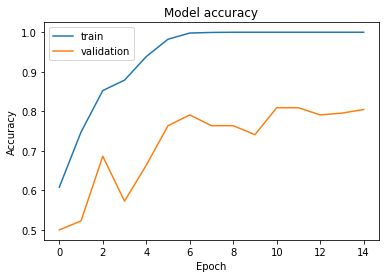

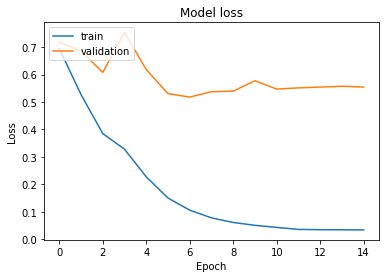

In [ ]:
results = return_training_values(model, train_L, train_R, train_Y)

without normalization

In [ ]:
model1 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][1])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 147456)       1196096     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 147456)       0           sequential_1[0][0]         

Epoch 1/30
62/62 [==============================] - 50s 784ms/step - loss: 0.7593 - accuracy: 0.5717 - val_loss: 0.6912 - val_accuracy: 0.5091
Epoch 2/30
62/62 [==============================] - 48s 779ms/step - loss: 0.4886 - accuracy: 0.7759 - val_loss: 0.6802 - val_accuracy: 0.5273
Epoch 3/30
62/62 [==============================] - 48s 779ms/step - loss: 0.3873 - accuracy: 0.8564 - val_loss: 0.5920 - val_accuracy: 0.6955
Epoch 4/30
62/62 [==============================] - 48s 778ms/step - loss: 0.2848 - accuracy: 0.9205 - val_loss: 0.5624 - val_accuracy: 0.7045
Epoch 5/30
62/62 [==============================] - 48s 780ms/step - loss: 0.2122 - accuracy: 0.9573 - val_loss: 0.6374 - val_accuracy: 0.6682
Epoch 6/30
62/62 [==============================] - 48s 781ms/step - loss: 0.1510 - accuracy: 0.9841 - val_loss: 0.5196 - val_accuracy: 0.7409
Epoch 7/30
62/62 [==============================] - 48s 777ms/step - loss: 0.1013 - accuracy: 0.9981 - val_loss: 0.5222 - val_accuracy: 0.7864

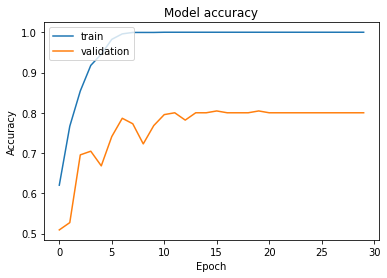

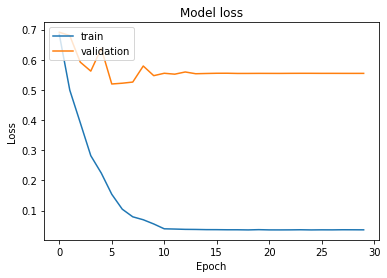

In [ ]:
results1 = return_training_values(model1, train_L, train_R, train_Y)

without early stop

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 147456)       1196096     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 147456)       0           sequential[0][0]             

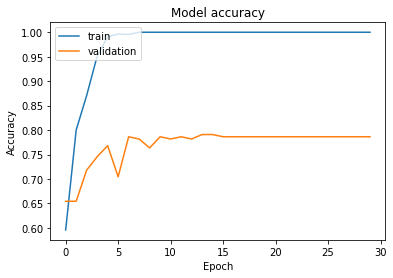

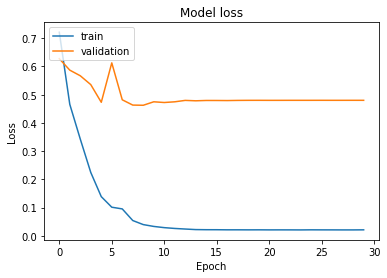

In [ ]:
model2 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][1])
results2 = return_training_values(model2, train_L, train_R, train_Y)

without batch norm

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 147456)       1194816     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 147456)       0           sequential_3[0][0]         

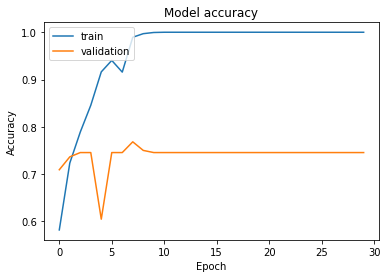

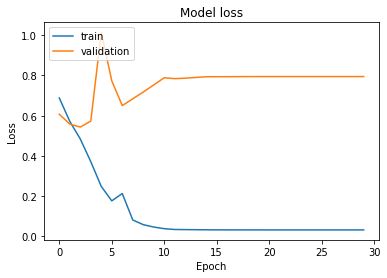

In [ ]:
model3 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][1], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][1])
results3 = return_training_values(model3, train_L, train_R, train_Y)

with normalization without early stop and without bach norm

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 147456)       1194816     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 147456)       0           sequential_4[0][0]         

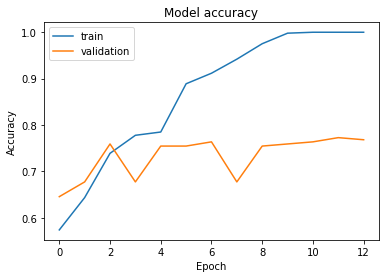

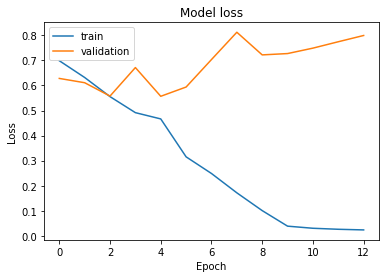

In [ ]:
model4 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][1], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][0])
results4 = return_training_values(model4, train_L, train_R, train_Y)

we see that the results are better without normalization, without early stop and with batch norm so we will continue with them and change the lr to 0.00003

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 147456)       1196096     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 147456)       0           sequential_1[0][0]         

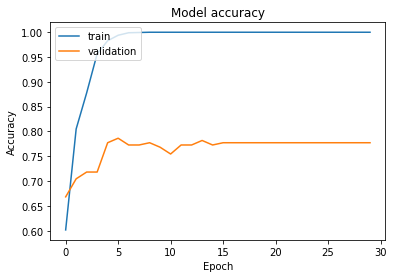

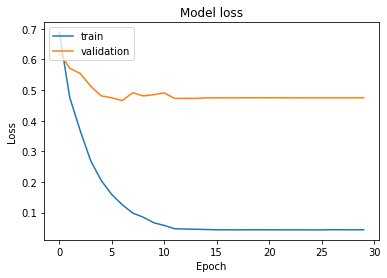

In [ ]:
model5 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][3],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][1])
results5 = return_training_values(model5, train_L, train_R, train_Y)

that is a bit worse, we will try to set a larger lr_decay -> 0.99

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 147456)       1196096     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 147456)       0           sequential_2[0][0]         

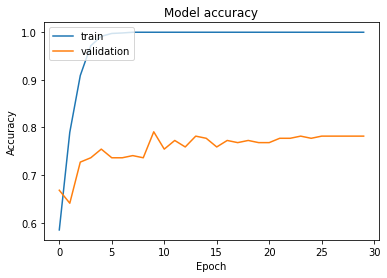

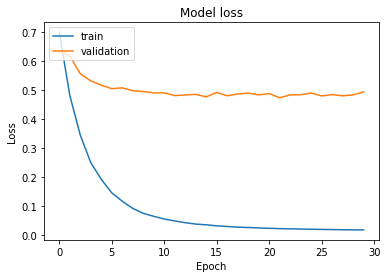

In [ ]:
model6 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][3],
                          parameters['lr_decay'][1], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][1])
results6 = return_training_values(model6, train_L, train_R, train_Y)

we will try the first lr->0.00006 which was better and change the l2

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 147456)       1196096     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 147456)       0           sequential_5[0][0]         

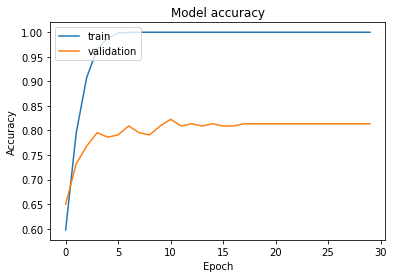

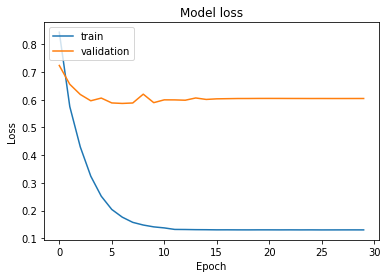

In [ ]:
model7 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][1],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][1])
results7 = return_training_values(model7, train_L, train_R, train_Y)

# image size of 250,250 and SGD optimizer

parameters - 'lr': [0.001, 0.002], 'lr_decay': [0.1, 0.99], 'batch_size': [32], 'l2_reg': [{'layer_1': 1e-4, 'layer_2': 1e-4, 'layer_3': 1e-4, 'layer_4': 1e-3}, {'layer_1': 1e-3, 'layer_2': 1e-3, 'layer_3': 1e-3, 'layer_4': 1e-3}], 'is_batch_norm': [True, False], 'epochs': [30], 'early_stop': [True, False]
'normlize': [True, False]

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 147456)       1196096     input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 147456)       0           sequential_6[0][0]         

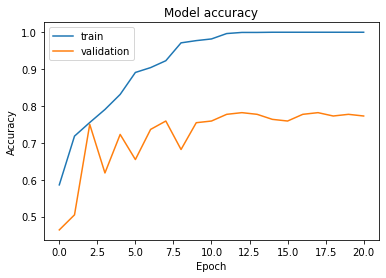

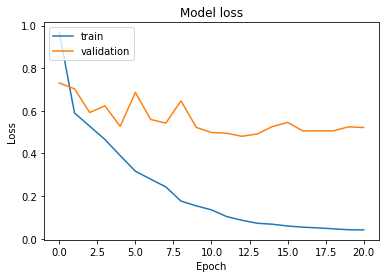

In [ ]:
model8 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][1],
                          parameters['lr_decay'][1], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][1],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][0])
results8 = return_training_values(model8, train_L, train_R, train_Y)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 147456)       1196096     input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 147456)       0           sequential_7[0][0]         

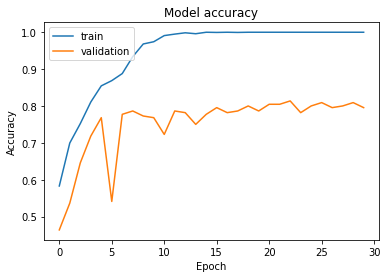

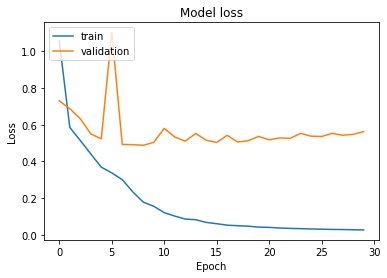

In [ ]:
model9 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][1],
                          parameters['lr_decay'][1], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][1],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][1])
results9 = return_training_values(model9, train_L, train_R, train_Y)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 147456)       1196096     input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 147456)       0           sequential_8[0][0]         

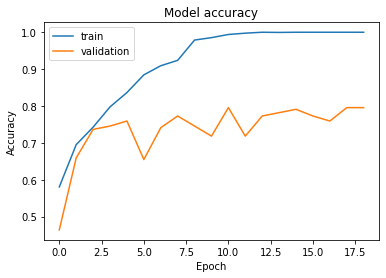

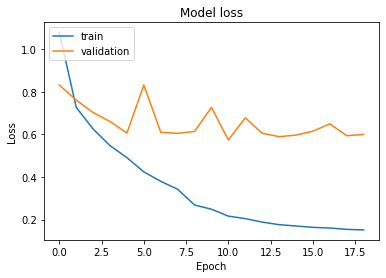

In [ ]:
model10 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][1],
                          parameters['lr_decay'][1], parameters['l2_reg'][1],
                          parameters['is_batch_norm'][0], parameters['opt'][1],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][0])
results10 = return_training_values(model10, train_L, train_R, train_Y)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 147456)       1196096     input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 147456)       0           sequential_9[0][0]         

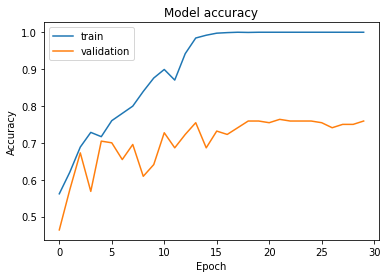

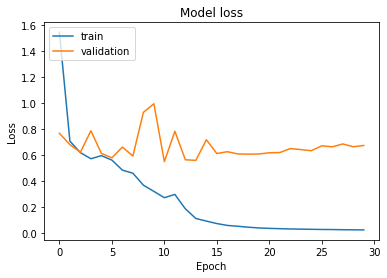

In [ ]:
model11 = Siamese_Network(parameters['img_shape'][1],parameters['lr'][2],
                          parameters['lr_decay'][1], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][1],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][1])
results11 = return_training_values(model11, train_L, train_R, train_Y)

image size of 150,150 and Adam optimizer

In [ ]:
train_L1, train_R1 = crop_image(train_L,72,72), crop_image(train_R,72,72)

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 4096)         38948928    input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 4096)         0           sequential_10[0][0]       

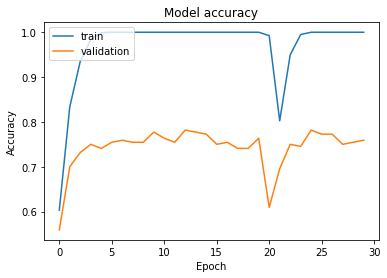

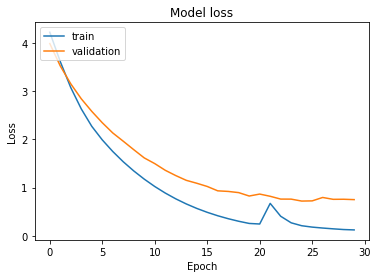

In [ ]:
model12 = Siamese_Network(parameters['img_shape'][0],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][1])
results12= return_training_values(model12, train_L1, train_R1, train_Y)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 4096)         38948928    input_23[0][0]                   
                                                                 input_24[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 4096)         0           sequential_11[0][0]       

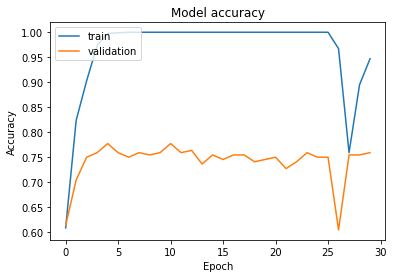

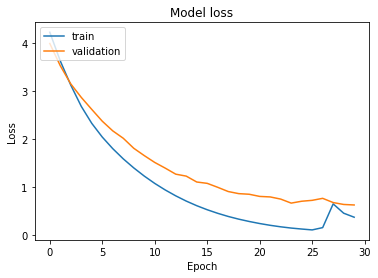

In [ ]:
model14 = Siamese_Network(parameters['img_shape'][0],parameters['lr'][0],
                          parameters['lr_decay'][0], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][0],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][1],parameters['normlize'][0])
results14= return_training_values(model14, train_L1, train_R1, train_Y)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 4096)         38948928    input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 4096)         0           sequential_12[0][0]       

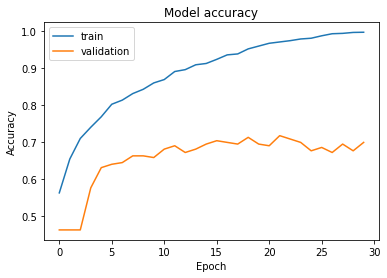

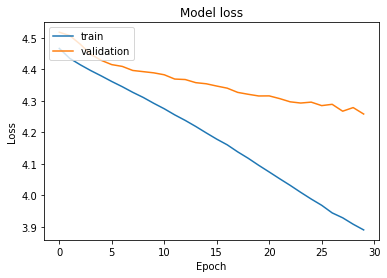

In [ ]:
model13 = Siamese_Network(parameters['img_shape'][0],parameters['lr'][2],
                          parameters['lr_decay'][1], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][1],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][1])
results13 = return_training_values(model13, train_L1, train_R1, train_Y)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 4096)         38948928    input_27[0][0]                   
                                                                 input_28[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 4096)         0           sequential_13[0][0]       

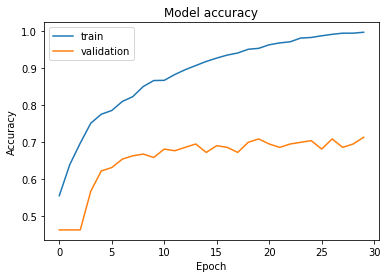

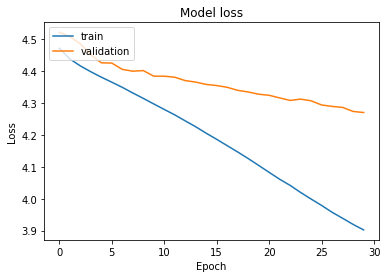

In [ ]:
model15 = Siamese_Network(parameters['img_shape'][0],parameters['lr'][2],
                          parameters['lr_decay'][1], parameters['l2_reg'][0],
                          parameters['is_batch_norm'][0], parameters['opt'][1],
                          parameters['epochs'][0],parameters['batch_size'][0],
                          parameters['early_stop'][0],parameters['normlize'][0])
results15 = return_training_values(model15, train_L1, train_R1, train_Y)

# test

In [ ]:
"""
plot wrong prediction exemples
"""
def plot_wrong_predictions(l, r, classes, true_lables ,number_of_exemples=4):
    fig = plt.figure(figsize=(32, 32))
    cnt = 0
    for i in range(len(classes)):
        if cnt < number_of_exemples*2:
            if classes[i] != true_lables[i]:
                sub = fig.add_subplot(number_of_exemples, number_of_exemples, cnt+1)
                sub.imshow(l[i], cmap='gray')
                sub.text(0.85, 0, f'pred: {classes[i]}, true: {true_lables[i]}', color='red', weight='bold', fontsize=20)
                sub = fig.add_subplot(number_of_exemples, number_of_exemples, cnt+2)
                sub.imshow(r[i],cmap='gray')
                cnt= cnt+2
        else:
            break

In [ ]:
test_L, test_R = load_image_data(test_X)
test_L, test_R = stack_values(test_L, test_R)

In [ ]:
from sklearn.metrics import accuracy_score

def test_prediciton_evaluation(model, test_L, test_R, test_Y):
    predictions = model.predict(test_L, test_R)
    classes = np.round(predictions).reshape(1000)
    y = test_Y.values
    print(f'accuracy over test: {accuracy_score(classes, y)}')
    plot_wrong_predictions(test_L, test_R, classes, test_Y)
    return classes

with (250, 250) image size

accuracy over test: 0.766


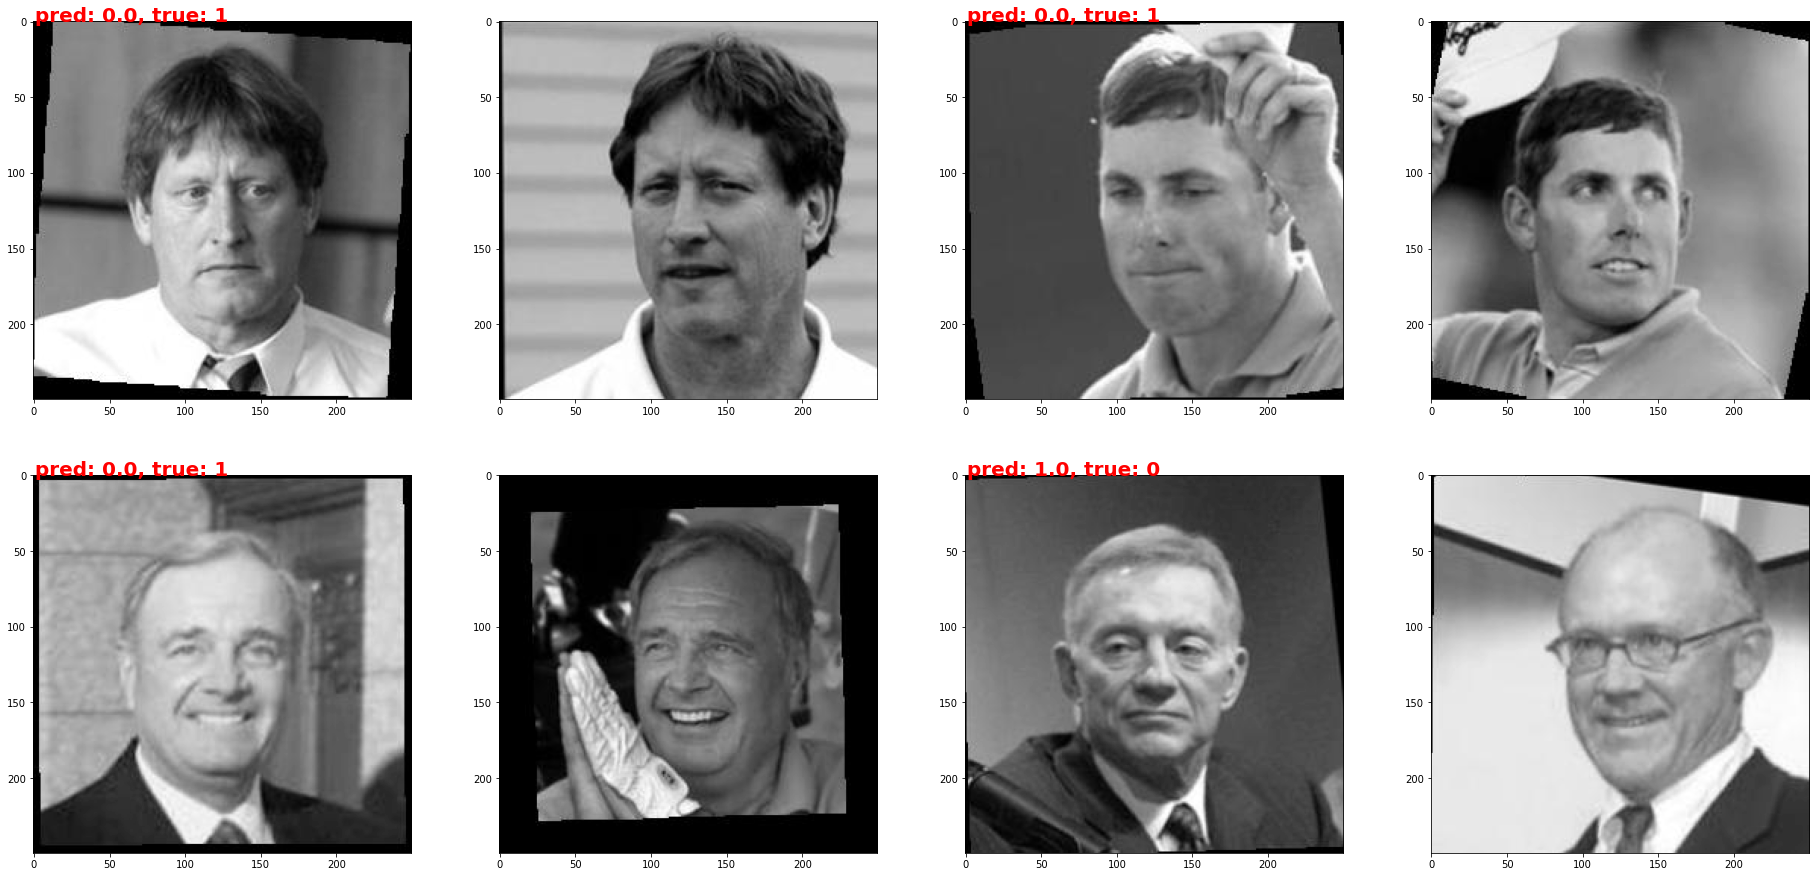

In [ ]:
classess = test_prediciton_evaluation(model2, test_L, test_R, test_Y)

accuracy over test: 0.754


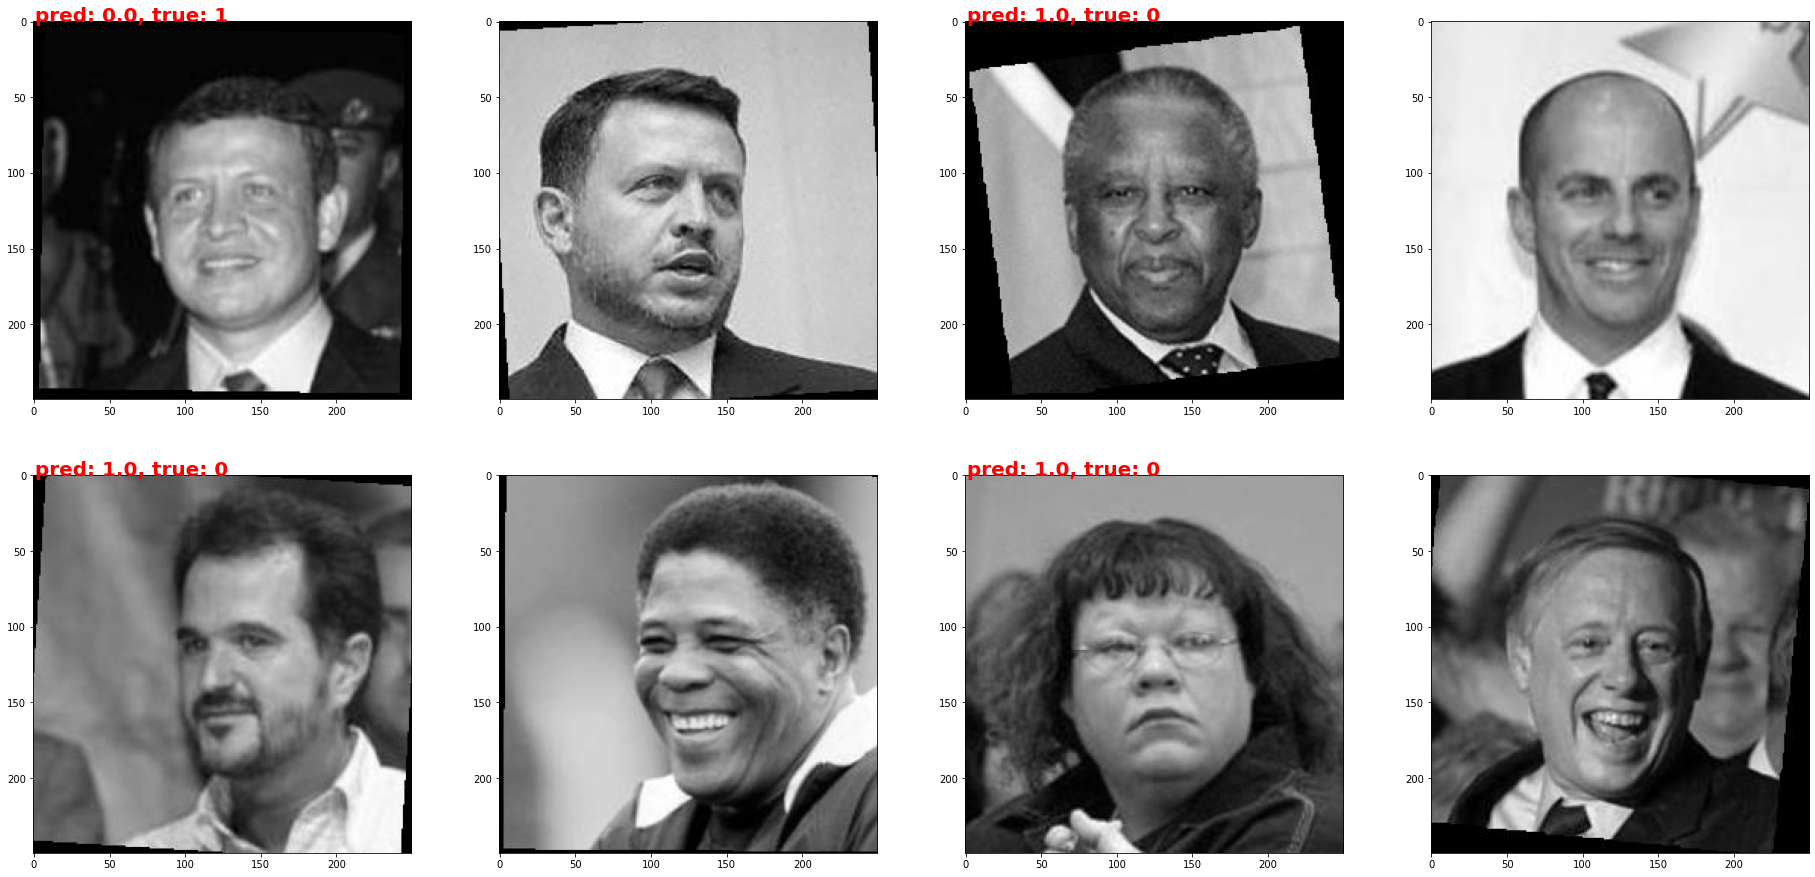

In [ ]:
classess1 = test_prediciton_evaluation(model11, test_L, test_R, test_Y)

accuracy over test: 0.744


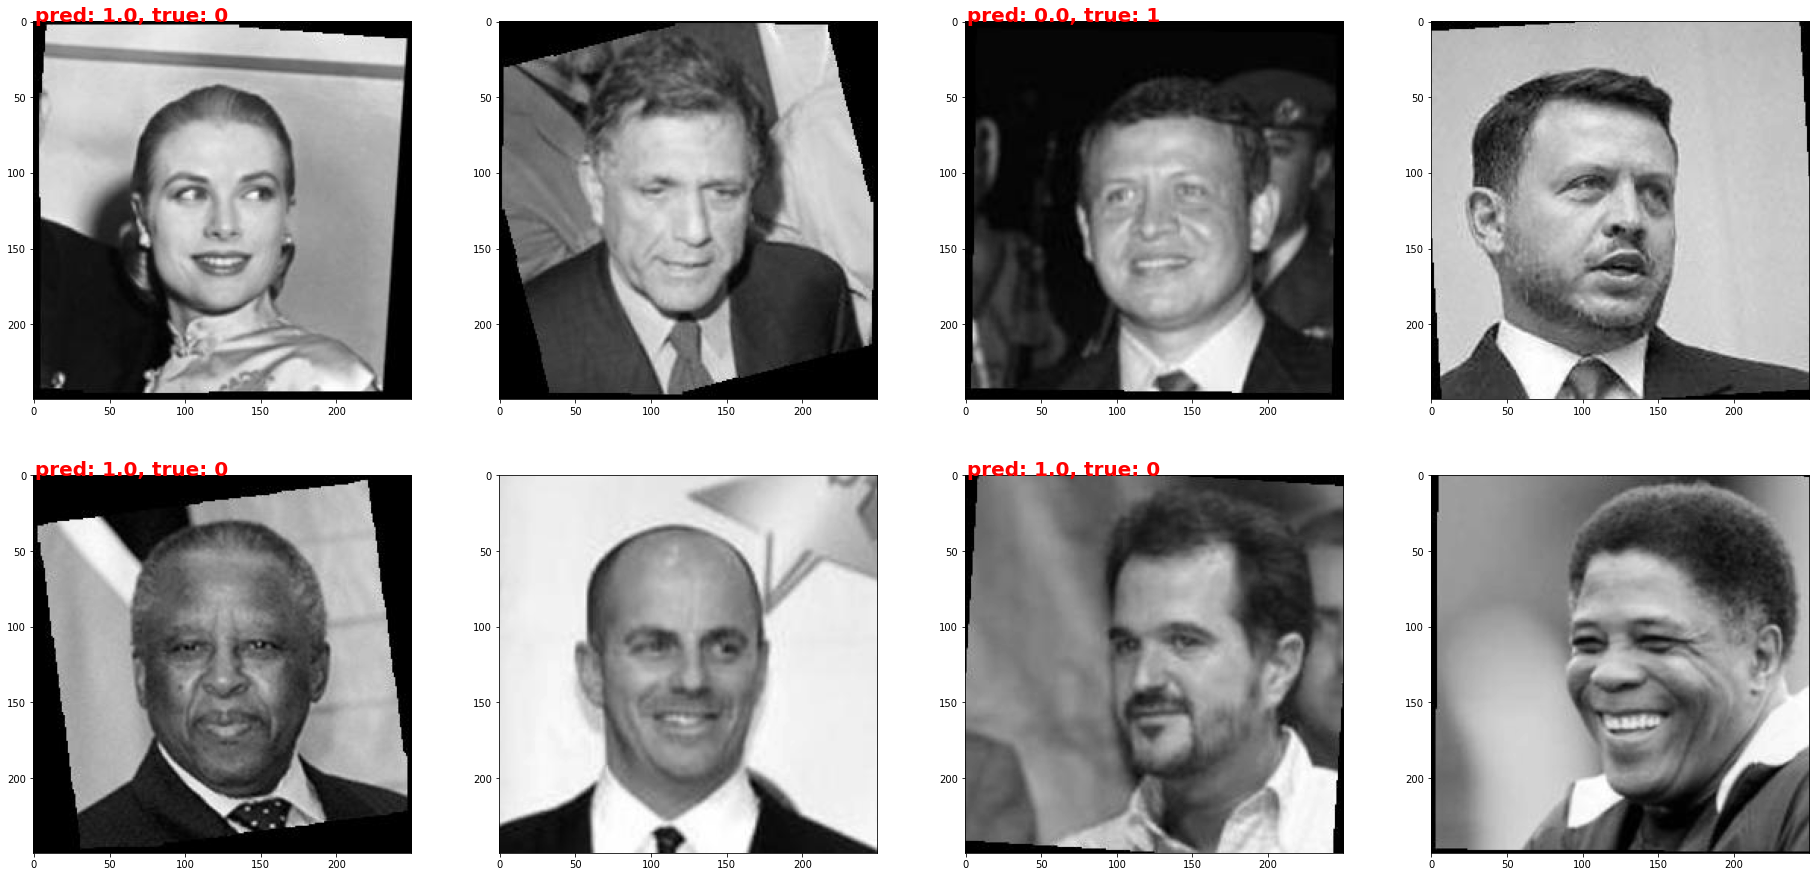

In [ ]:
classess2 = test_prediciton_evaluation(model8, test_L, test_R, test_Y)

In [ ]:
test_L1, test_R1 = crop_image(test_L,72,72), crop_image(test_R,72,72)

accuracy over test: 0.713


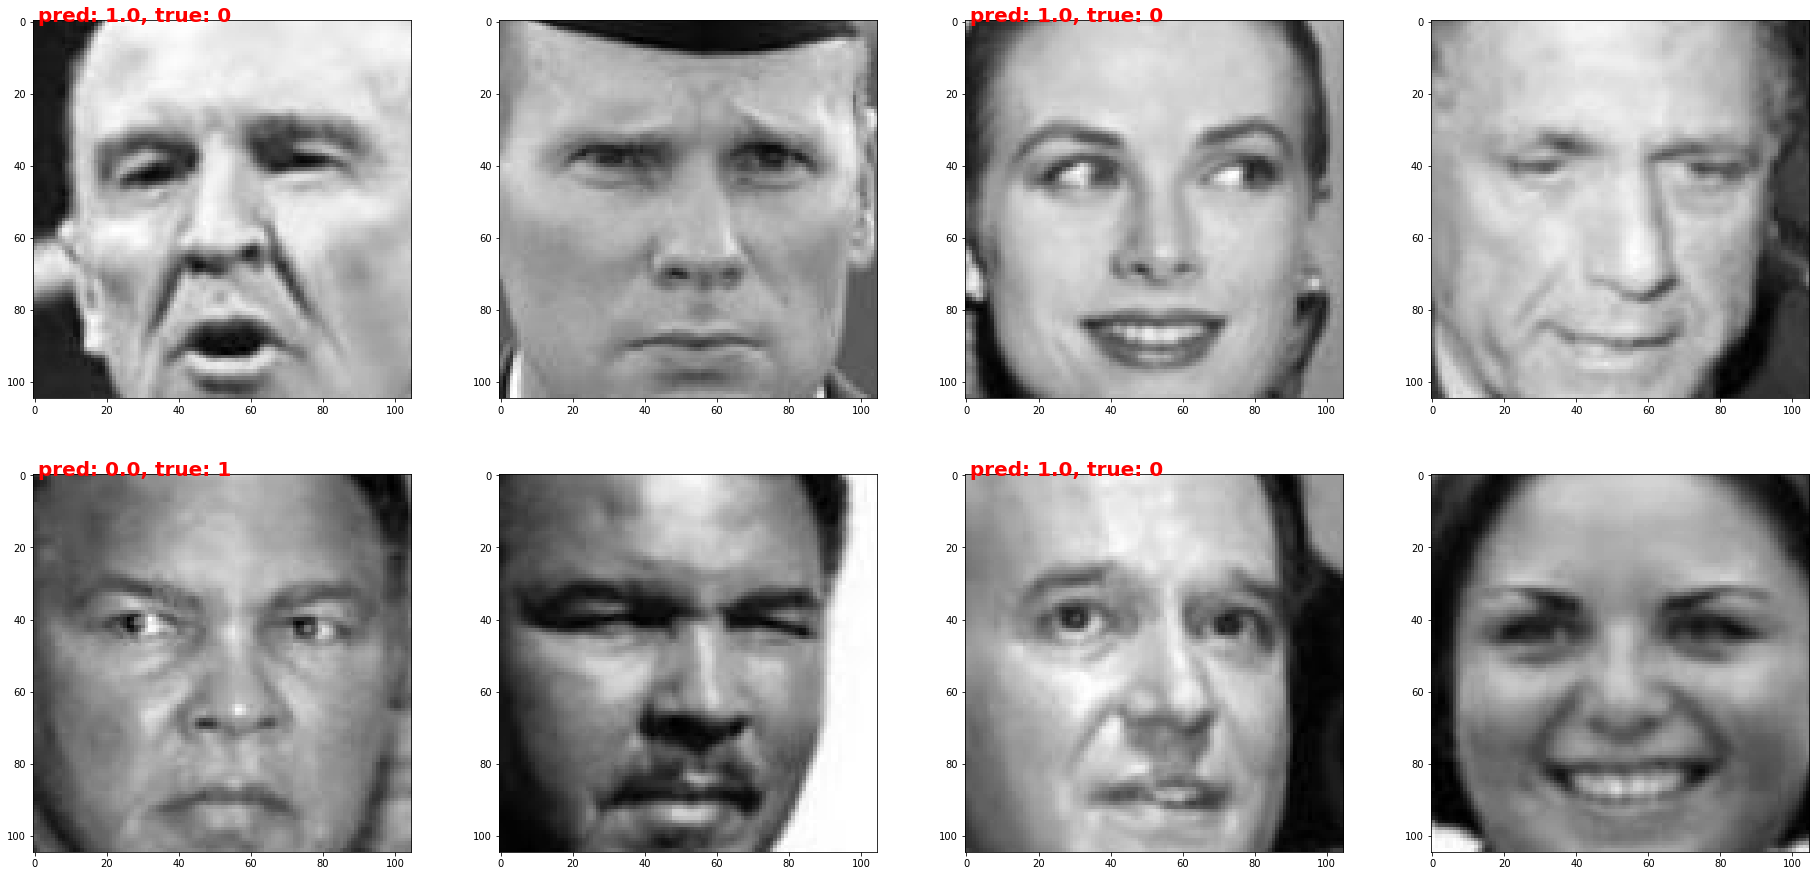

In [ ]:
classess3 = test_prediciton_evaluation(model13, test_L1, test_R1, test_Y)

accuracy over test: 0.687


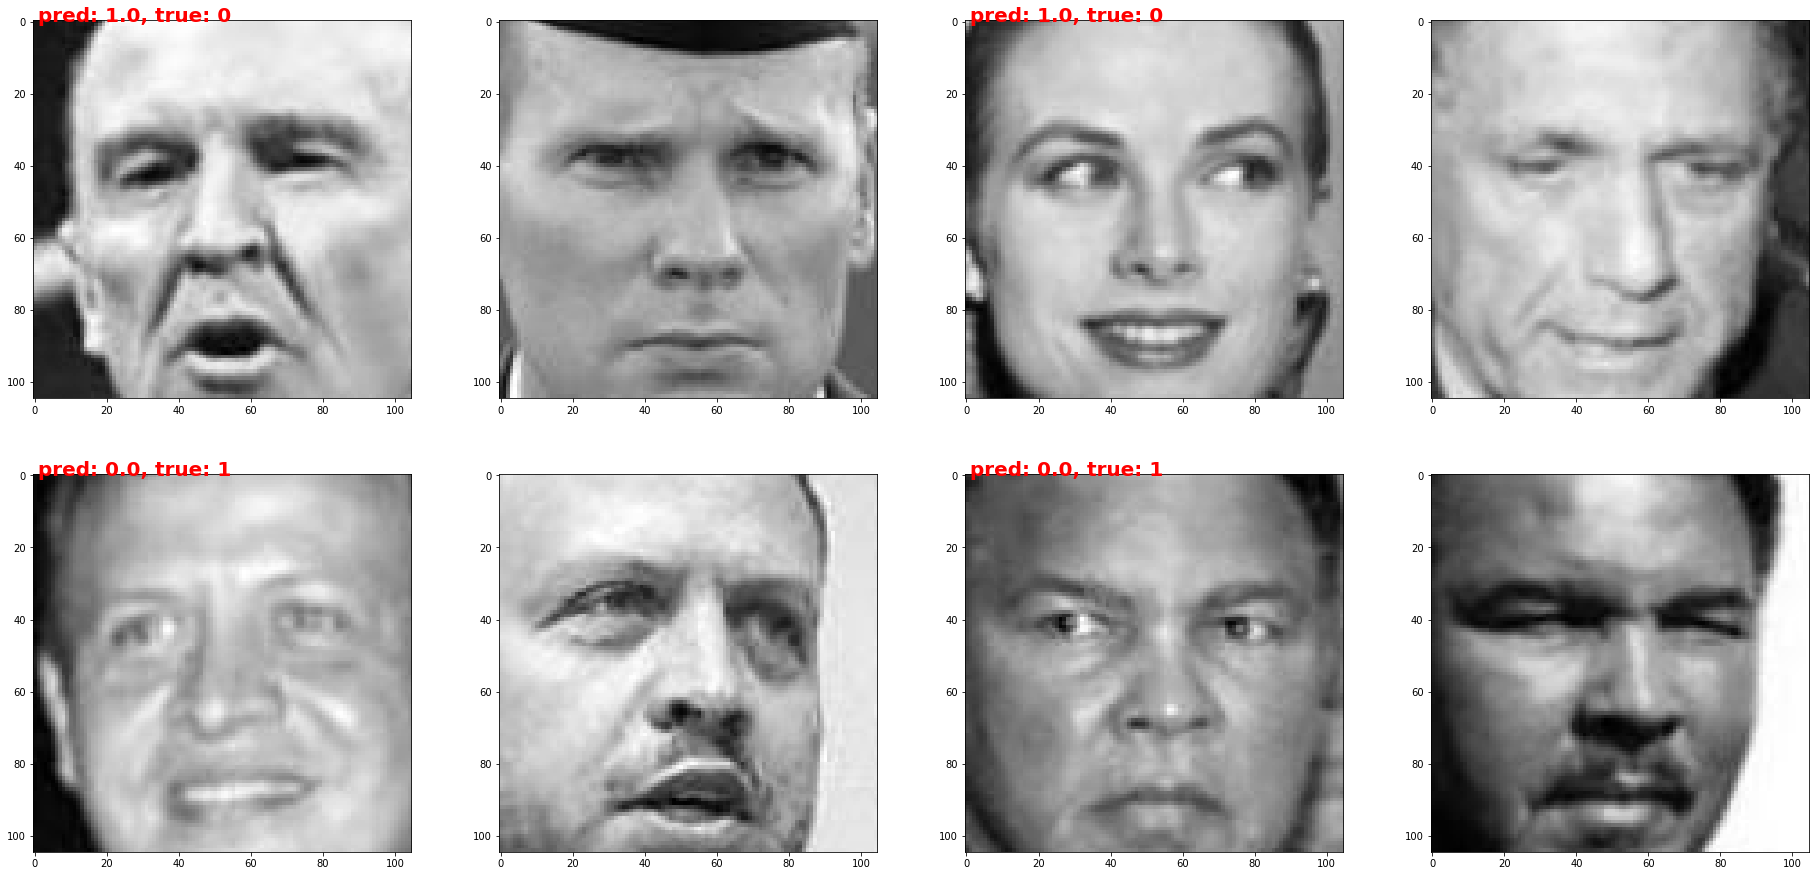

In [ ]:
classess3 = test_prediciton_evaluation(model15, test_L1, test_R1, test_Y)